## Obtaining Census Data for Reproduction of Spielman Paper

In [1]:
# Import modules, define directories
import pygris
import pandas as pd
import geopandas as gpd
from pygris.utils import shift_geometry
from pygris.data import get_census
from pygris import counties
from pyhere import here
import numpy as np

path = {
    "dscr": here("data", "scratch"),
    "drpub": here("data", "raw", "public"),
    "drpriv": here("data", "raw", "private"),
    "ddpub": here("data", "derived", "public"),
    "ddpriv": here("data", "derived", "private"),
    "rfig": here("results", "figures"),
    "roth": here("results", "other"),
    "rtab": here("results", "tables")
}

In [2]:
# Record raw variable names for Spielman et al's data and our own
acs_variables = [
    "B01002_001E", # median age
    "B03002_001E", # total population (demoninator for race)
    "B03002_004E", # total black
    "B03002_005E", # total native american
    "B03002_006E", # total asian
    "B03002_012E", # total latinx
    "B06001_002E", # total under 5
    "B09020_001E", # total above 65 -- they got from different section than under 5. Try summing B06001_011E + B06001_012E and see if result is equivalent?
    "B01003_001E", # total population (denominator for age, sex) -- check if this is the best denominator for age
    "B25008_001E", # total population in occupied housing units?
    "B25002_002E", # total occupied housing units? Believe they divide B25008_001E/B25002_002E to get people per 
    "B25003_003E", # total renter occupied housing units?
    "B25002_001E", # total housing units for which occupancy status is known?
    "B09020_021E", # total 65+ living in group quarters
    "B01001_026E", # total female
    "B11001_006E", # total female-headed family households
    "B11001_001E", # total households (denominator for pct female-headed)
    "B25002_003E", # total vacant housing units?
    "B19025_001E", # aggregate household income
    "B16004_029E", # total speak spanish, speak english not well ages 18-64
    "B16004_030E", # total speak spanish, speak english not at all ages 18-64
    "B16004_034E", # total speak other indo-european languages, speak english not well ages 18-64
    "B16004_035E", # total speak other indo-european languages, speak english not at all ages 18-64
    "B16004_039E", # total speak asian languages, speak english not well ages 18-64
    "B16004_040E", # total speak asian languages, speak english not at all ages 18-64
    "B16004_044E", # total speak other languages, speak english not well ages 18-64
    "B16004_045E", # total speak other languages, speak english not at all ages 18-64
    "B16004_051E", # total speak spanish, speak english not well ages 65+
    "B16004_052E", # total speak spanish, speak english not at all ages 65+
    "B16004_056E", # total speak other indo-european languages, speak english not well ages 65+
    "B16004_057E", # total speak other indo-european languages, speak english not at all ages 65+
    "B16004_061E", # total speak asian languages, speak english not well ages 65+
    "B16004_062E", # total speak asian languages, speak english not at all ages 65+
    "B16004_066E", # total speak other languages, speak english not well ages 65+
    "B16004_067E", # total speak other languages, speak english not at all ages 65+
    "B16004_024E", # total ages 18-64 for language category
    "B16004_046E", # total 65+ for language category
    "B16004_025E", # total ages 18-64 that speak only english
    "B16004_047E", # total 65+ that speak only english
    "B23022_025E", # total male unemployed for last 12 months -- did they not have the stat available without the male/female cross tabulation?
    "B23022_049E", # total female unemployed for last 12 months
    "B23022_001E", # total for unemployment by sex stats
    "B17021_002E", # total pop below poverty level
    "B17021_001E", # total pop for which poverty info available (denominator for poverty pct)
    "B25024_010E", # number of mobile home housing units in structure
    "B25024_001E", # total units in structure
    "B15002_003E", # total male no schooling completed
    "B15002_004E", # total male nursery to 4th grade
    "B15002_005E", # total male 5th and 6th grade
    "B15002_006E", # total male 7th and 8th grade
    "B15002_007E", # total male 9th grade
    "B15002_008E", # total male 10th grade
    "B15002_009E", # total male 11th grade
    "B15002_010E", # total male 12th grade, no diploma
    "B15002_020E", # total female no schooling completed
    "B15002_021E", # total female nursery to 4th grade
    "B15002_022E", # total female 5th and 6th grade
    "B15002_023E", # total female 7th and 8th grade
    "B15002_024E", # total female 9th grade
    "B15002_025E", # total female 10th grade
    "B15002_026E", # total female 11th grade
    "B15002_027E", # total female 12th grade, no diploma
    "B15002_001E", # total sex by educational attainment (denominator for education)
    "C24010_038E", # total female employed
    "C24010_001E", # total for which sex and occupation -- including employment status -- known (a denominator)
    "C24030_003E", # total male extractive industries
    "C24030_030E", # total female extractive industries
    "C24030_001E", # total for which sex and industry known
    "C24010_019E", # total male in service occupations
    "C24010_055E", # total female in service occupations
    "B19055_002E", # total households(?) with social security income
    "B19055_001E", # total households(?) for which social security income status known
    "B25044_003E", # total owner occupied no vehicle available
    "B25044_010E", # total rental occupied no vehicle available
    "B25044_001E", # total for which tenure by vehicle available known
    "B09002_002E", # total children in married couple families
    "B09002_001E", # total children by family type and age (a denominator)
    "B19001_017E", # total households over 200k income
    "B11001_001E", # total households (denominator -- is there an alternative from same category? B19001_001E?)
    "B06007_005E", # total speak spanish, speak english less than very well
    "B06007_008E", # total speak another language, speak english less than very well
    "B06007_001E", # total speak another language (a denominator)
    "B16010_002E", # total less than high school
    "B16010_001E", # total for which education, employment, language at home known (a denominator)
    "C24050_002E", # total in extractive industries
    "C24050_001E", # total for which industry known (a denominator)
    "C24050_029E", # total in service occupations
    "B08201_002E", # total households no vehicle available
    "B08201_001E", # total households for which vehicle status and family size known (a denominator)
    "B25064_001E", # median gross rent
    "B25077_001E", # median value (of what? housing?)
]
    
spielman_acs_variables = [
    "ACS12_5yr_B01002001", # median age
    "ACS12_5yr_B03002001", # total population (demoninator for race)
    "ACS12_5yr_B03002004", # total black
    "ACS12_5yr_B03002005", # total native american
    "ACS12_5yr_B03002006", # total asian
    "ACS12_5yr_B03002012", # total latinx
    "ACS12_5yr_B06001002", # total under 5 
    "ACS12_5yr_B09020001", # total above 65 -- they got from different section than under 5. Try summing B06001_011E + B06001_012E and see if result is equivalent?
    "ACS12_5yr_B01003001", # total population (denominator for age, sex) -- check if this is the best denominator for age
    "ACS12_5yr_B25008001", # total population in occupied housing units?
    "ACS12_5yr_B25002002", # total occupied housing units? Believe they divide B25008_001E/B25002_002E to get people per 
    "ACS12_5yr_B25003003", # total renter occupied housing units?
    "ACS12_5yr_B25002001", # total housing units for which occupancy status is known?
    "ACS12_5yr_B09020021", # total 65+ living in group quarters
    "ACS12_5yr_B01001026", # total female
    "ACS12_5yr_B11001006", # total female-headed family households
    "ACS12_5yr_B11001001", # total households (denominator for pct female-headed)
    "ACS12_5yr_B25002003", # total vacant housing units?
    "ACS12_5yr_B19025001", # aggregate household income
    "ACS12_5yr_B16004029", # total speak spanish, speak english not well ages 18-64
    "ACS12_5yr_B16004030", # total speak spanish, speak english not at all ages 18-64
    "ACS12_5yr_B16004034", # total speak other indo-european languages, speak english not well ages 18-64
    "ACS12_5yr_B16004035", # total speak other indo-european languages, speak english not at all ages 18-64
    "ACS12_5yr_B16004039", # total speak asian languages, speak english not well ages 18-64
    "ACS12_5yr_B16004040", # total speak asian languages, speak english not at all ages 18-64
    "ACS12_5yr_B16004044", # total speak other languages, speak english not well ages 18-64
    "ACS12_5yr_B16004045", # total speak other languages, speak english not at all ages 18-64
    "ACS12_5yr_B16004051", # total speak spanish, speak english not well ages 65+
    "ACS12_5yr_B16004052", # total speak spanish, speak english not at all ages 65+
    "ACS12_5yr_B16004056", # total speak other indo-european languages, speak english not well ages 65+
    "ACS12_5yr_B16004057", # total speak other indo-european languages, speak english not at all ages 65+
    "ACS12_5yr_B16004061", # total speak asian languages, speak english not well ages 65+
    "ACS12_5yr_B16004062", # total speak asian languages, speak english not at all ages 65+
    "ACS12_5yr_B16004066", # total speak other languages, speak english not well ages 65+
    "ACS12_5yr_B16004067", # total speak other languages, speak english not at all ages 65+
    "ACS12_5yr_B16004024", # total ages 18-64 for language category
    "ACS12_5yr_B16004046", # total 65+ for language category
    "ACS12_5yr_B16004025", # total ages 18-64 that speak only english
    "ACS12_5yr_B16004047", # total 65+ that speak only english
    "ACS12_5yr_B23022025", # total male unemployed for last 12 months -- did they not have the stat available without the male/female cross tabulation?
    "ACS12_5yr_B23022049", # total female unemployed for last 12 months
    "ACS12_5yr_B23022001", # total for unemployment by sex stats
    "ACS12_5yr_B17021002", # total pop below poverty level
    "ACS12_5yr_B17021001", # total pop for which poverty info available (denominator for poverty pct)
    "ACS12_5yr_B25024010", # number of mobile home housing units in structure
    "ACS12_5yr_B25024001", # total units in structure
    "ACS12_5yr_B15002003", # total male no schooling completed
    "ACS12_5yr_B15002004", # total male nursery to 4th grade
    "ACS12_5yr_B15002005", # total male 5th and 6th grade
    "ACS12_5yr_B15002006", # total male 7th and 8th grade
    "ACS12_5yr_B15002007", # total male 9th grade
    "ACS12_5yr_B15002008", # total male 10th grade
    "ACS12_5yr_B15002009", # total male 11th grade
    "ACS12_5yr_B15002010", # total male 12th grade, no diploma
    "ACS12_5yr_B15002020", # total female no schooling completed
    "ACS12_5yr_B15002021", # total female nursery to 4th grade
    "ACS12_5yr_B15002022", # total female 5th and 6th grade
    "ACS12_5yr_B15002023", # total female 7th and 8th grade
    "ACS12_5yr_B15002024", # total female 9th grade
    "ACS12_5yr_B15002025", # total female 10th grade
    "ACS12_5yr_B15002026", # total female 11th grade
    "ACS12_5yr_B15002027", # total female 12th grade, no diploma
    "ACS12_5yr_B15002001", # total sex by educational attainment (denominator for education)
    "ACS12_5yr_C24010038", # total female employed
    "ACS12_5yr_C24010001", # total for which sex and occupation -- including employment status -- known (a denominator)
    "ACS12_5yr_C24030003", # total male extractive industries
    "ACS12_5yr_C24030030", # total female extractive industries
    "ACS12_5yr_C24030001", # total for which sex and industry known
    "ACS12_5yr_C24010019", # total male in service occupations
    "ACS12_5yr_C24010055", # total female in service occupations
    "ACS12_5yr_B19055002", # total households(?) with social security income
    "ACS12_5yr_B19055001", # total households(?) for which social security income status known
    "ACS12_5yr_B25044003", # total owner occupied no vehicle available
    "ACS12_5yr_B25044010", # total rental occupied no vehicle available
    "ACS12_5yr_B25044001", # total for which tenure by vehicle available known
    "ACS12_5yr_B09002002", # total children in married couple families
    "ACS12_5yr_B09002001", # total children by family type and age (a denominator)
    "ACS12_5yr_B19001017", # total households over 200k income
    "ACS12_5yr_B11001001", # total households (denominator -- is there an alternative from same category? B19001_001E?)
    "ACS12_5yr_B06007005", # total speak spanish, speak english less than very well
    "ACS12_5yr_B06007008", # total speak another language, speak english less than very well
    "ACS12_5yr_B06007001", # total speak another language (a denominator)
    "ACS12_5yr_B16010002", # total less than high school
    "ACS12_5yr_B16010001", # total for which education, employment, language at home known (a denominator)
    "ACS12_5yr_C24050002", # total in extractive industries
    "ACS12_5yr_C24050001", # total for which industry known (a denominator)
    "ACS12_5yr_C24050029", # total in service occupations
    "ACS12_5yr_B08201002", # total households no vehicle available
    "ACS12_5yr_B08201001", # total households for which vehicle status and family size known (a denominator)
    "ACS12_5yr_B25064001", # median gross rent
    "ACS12_5yr_B25077001", # median value (of what? housing?)
]
    
# *looks like they calculate some things in a slightly slower way and then recalculate them with fewer vars

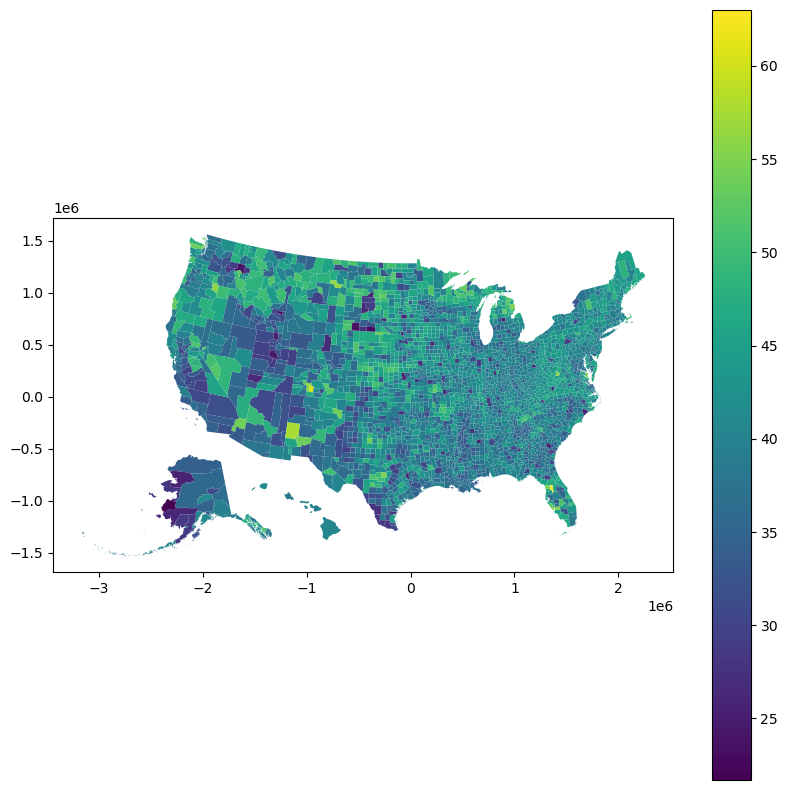

In [3]:
# Obtain our data from the census using pygris

# Acquire attribute data
counties_detailed = get_census(dataset = "acs/acs5", # dataset name on the Census API you are connecting to; find datasets at https://api.census.gov/data.html
                        variables = acs_variables, # string (or list of strings) of desired vars. For the 2021 5-year ACS Data Profile, those variable IDs are found at https://api.census.gov/data/2021/acs/acs5/profile/variables.html.
                        year = 2012, # year of your data (or end-year for a 5-year ACS sample)
                        params = { # dict of query parameters to send to the API.
                          "for": "county:*"},#,
                          # "in": "state:36"},
                        guess_dtypes = True,
                        return_geoid = True)

# Acquire geographical data
counties_shp = counties(cb = True, year = 2010, cache = True) # year 2012 not available
counties_shp['GEOID'] = counties_shp.STATE + counties_shp.COUNTY
counties_shp['CENSUSAREA'] = counties_shp.CENSUSAREA.round(0)

# Join the data and map it
counties = counties_shp.merge(counties_detailed, how = "inner", on = "GEOID")
counties = counties[counties.STATE != '72']
counties_pretty = shift_geometry(counties)
counties_pretty.plot(column = "B01002_001E", legend = True, figsize = (10, 10)); # believe plot() from gpd

In [4]:
# Define a function that can determine whether every entry in specified columns of two tables match  
def equiv(table1, sort1, column1, table2, sort2, column2):
    ''' 
    Tests two tables to see whether corresponding columns have equivalent entries.
    
    Parameters:
    table1 - the first table
    sort1 - the column in the first table to join by (str)
    column1 - the column(s) in the first table to test the values of (list of str) (should list analogous columns for columns2) 
    table2 - the second table
    sort2 - the column in the second table to join by (str)
    column2 - the column(s) in the second table to test the values of (list of str)
    '''
    # Sort tables
    table1 = table1.sort_values(by = sort1).reset_index()
    table2 = table2.sort_values(by = sort2).reset_index()
    
    # Rename column name in table2 to match that in table1
    for i in range(len(column1)):
        table2 = table2.rename(columns={column2[i]: column1[i]})

    # Select the columns to test equivalency of
    table1 = table1[column1]
    table2 = table2[column1]
    
    # Perform equivalency test
    test = table1.eq(table2)
    return test

In [5]:
%%script echo skipping # Cell magic to not run this code chunk

# A toy example to illustrate how the function works

# Create two DataFrames from dictionaries
data1 = {
    "id": [1,2,3],
    "calories": [420, 380, 390],
    "duration": [50, 40, 45]
}

data1 = pd.DataFrame(data1)

data2 = {
    "identifier": [1,2,3],
    "caloriesayy": [420, 380, 390],
    "durationyayy": [50, 40, 0]
}

data2 = pd.DataFrame(data2)

# Perform equivalency test
test = equiv(data1, "id", ["calories", "duration"], data2, "identifier", ["caloriesayy", "durationyayy"])
test#.sum() # optionally use .sum() to determine how many entries match

skipping # Cell magic to not run this code chunk


In [6]:
# Import raw data from Spielman et al

# Import base ACS data
make_strings = {'Geo_FIPS': object, 'Geo_STATE': object, 'Geo_COUNTY': object,
                'Geo_TRACT': object, 'Geo_CBSA': object, 'Geo_CSA': object}

acs = pd.read_csv(here(path["drpub"], 'sovi_acs.csv'),
                  dtype=make_strings, skiprows=1,encoding='latin-1')

# Import, join a decennial supplemental
dec_sup1 = pd.read_csv(here(path["drpub"],'sovi_decennial_sup1.csv'),
        dtype=make_strings,skiprows=1,encoding='latin-1')

acs = acs.merge(dec_sup1, how = "inner", on='Geo_FIPS')

# Import, join an ACS supplemental
acs_sup2 = pd.read_csv(here(path["drpub"], 'sovi_acs_kids.csv'),
                           dtype=make_strings, skiprows=1,encoding='latin-1')

acs = acs.merge(acs_sup2, how = "inner", on='Geo_FIPS')

# Round area column
acs['SE_T02A_002'] = acs.SE_T02A_002.round(0)

# Drop Puerto Rico to avoid issues with missing data
acs = acs[acs.Geo_STATE_x != '72'] 

In [7]:
# Add the area variables to the lists of variables
acs_variables.append('CENSUSAREA')
spielman_acs_variables.append('SE_T02A_002')

In [8]:
# Perform equivalency test
test = equiv(counties, "GEOID", acs_variables, acs, "Geo_FIPS", spielman_acs_variables)
matching_cols = pd.DataFrame({"test": test.sum().eq(3143)}) # 3143 matches the number of rows (3221 if PR included)
matching_cols.loc[~matching_cols.test] # Identify the columns that have some data discrepencies

,test
B25077_001E,False
CENSUSAREA,False


The following variables have some discrepancy between their dataset and mine:
- B25077_001E
- CENSUSAREA

Sidenote: because we removed Puerto Rico from the analysis, we eliminated discrepancies (due to NAs) due to these variables:
- B06001_002E
- B06007_005E
- B06007_008E
- B06007_001E


In [9]:
# Show the rows for which there are data discrepancies (false means discrepancy)
messed_up_indices = test[["CENSUSAREA", "B25077_001E"]].loc[~test.CENSUSAREA |~test.B25077_001E]
messed_up_indices

,CENSUSAREA,B25077_001E
471,False,True
548,True,False
673,False,True
2087,False,True


In [10]:
# Inspect the data values at the indices that are mis-matched

# Select the data of interest from tygris
tygris_data = counties.sort_values(by = "GEOID")\
    .reset_index().loc[messed_up_indices.index]\
    [["GEOID", "CENSUSAREA", "B25077_001E"]]

# Select the data of interest from Spielman et al
spielman_data = acs.sort_values(by = "Geo_FIPS")\
    .reset_index().loc[messed_up_indices.index]\
    [["Geo_FIPS", "SE_T02A_002", "ACS12_5yr_B25077001"]]

# Join and inspect
merged = tygris_data.merge(spielman_data, how = "inner", left_on = "GEOID", right_on = "Geo_FIPS")
merged

,GEOID,CENSUSAREA,B25077_001E,Geo_FIPS,SE_T02A_002,ACS12_5yr_B25077001
0,13171,184.0,119800.0,13171,183.0,119800.0
1,15005,12.0,NaN,15005,12.0,NaN
2,17157,576.0,89300.0,17157,575.0,89300.0
3,39089,682.0,151300.0,39089,683.0,151300.0


By inspection, we see that the one disagreement between B25077_001E and ACS12_5yr_B25077001 occurs because of a NaN value in an analogous location in each of the two datasets.

We also see that in the 3 cases where we have a disagreement between CENSUSAREA and SE_T02A_002, the two values differ only by 1 (this variable was rounded to the 1's place). This minor discrepancy is unlikely to influence our results.

Thus, our data sufficiently matches Spielman et al's. Also, this shows us that we need to impute a missing value for one NaN in B25077_001E.

### Data Prep -- Beginning to Work through Spielman et al's work

In [16]:
is_numeric_dtype(counties['B25077_001E'])

NameError: name 'is_numeric_dtype' is not defined

In [26]:
# Check for missing data
for i in counties.columns:
    x = counties[i].isnull().sum()
    if x > 0:
        print(i, x)
        
# Check for infinities
counties_num = counties.select_dtypes(include=['int64','float64'])
for i in counties_num.columns:
    xmin = counties_num[i].min()
    xmax = counties_num[i].max()
    if xmin == -np.inf:
        print(i, "contains a negative infinity")
    elif xmax == np.inf:
        print(i, "contains a positive infinity")

LSAD 2
B25077_001E 1


Of the two variables with missing data, we only use one of them -- B25077_001E -- to calculate our variables for PCA.

In [ ]:
counties['MEDAGE_ACS'] = counties.B01002_001E
counties['BLACK_ACS'] = counties.B03002_004E / (counties.B03002_001E)
counties['QNATAM_ACS'] = counties.B03002_005E / (counties.B03002_001E)
counties['QASIAN_ACS'] = counties.B03002_006E / (counties.B03002_001E)
counties['QHISP_ACS'] = counties.B03002_012E / (counties.B03002_001E)
counties['QAGEDEP_ACS'] = (counties.B06001_002E + counties.B09020_001E) / (counties.B01003_001E)
counties['QPUNIT_ACS'] = counties.B25008_001E / (counties.B25002_002E)
counties['PRENTER_ACS'] = counties.B25003_003E / (counties.B25002_001E)
counties['QNRRES_ACS'] = counties.B09020_021E / (counties.B01003_001E)
counties['QFEMALE_ACS'] = counties.B01001_026E / (counties.B01003_001E)
counties['QFHH_ACS'] = counties.B11001_006E / (counties.B11001_001E)
counties['QUNOCCHU_ACS'] = counties.B25002_003E / (counties.B25002_001E)
counties['PERCAP'] = counties.B19025_001E / (counties.B01003_001E)
counties['QESL'] = (counties.B16004_029E + counties.B16004_030E +
                counties.B16004_034E + counties.B16004_035E +
                counties.B16004_039E + counties.B16004_040E +
                counties.B16004_044E + counties.B16004_045E +
                counties.B16004_051E + counties.B16004_052E +
                counties.B16004_056E + counties.B16004_057E +
                counties.B16004_061E + counties.B16004_062E +
                counties.B16004_066E + counties.B16004_067E) / \
              ((counties.B16004_024E + counties.B16004_046E) - (counties.B16004_025E + counties.B16004_047E))
# Imputation that seems unnecessary
# counties.QESL = counties.QESL.replace([np.inf, -np.inf, np.nan], 0)
# counties.QESL = counties.QESL.replace([np.inf, -np.inf], 0)
counties['QCVLUN'] = (counties.B23022_025E + counties.B23022_049E) / \
                counties.B23022_001E
counties['QPOVTY'] = (counties.B17021_002E) / counties.B17021_001E
counties['QMOHO'] = (counties.B25024_010E) / counties.B25024_001E
counties['QED12LES'] = (counties.B15002_003E + counties.B15002_004E +
                    counties.B15002_005E + counties.B15002_006E +
                    counties.B15002_007E + counties.B15002_008E +
                    counties.B15002_009E + counties.B15002_010E +
                    counties.B15002_020E + counties.B15002_021E +
                    counties.B15002_022E + counties.B15002_023E +
                    counties.B15002_024E + counties.B15002_025E +
                    counties.B15002_026E + counties.B15002_027E) / \
                    counties.B15002_001E
counties['QFEMLBR'] = (counties.C24010_038E) / counties.C24010_001E
counties['QEXTRCT'] = (counties.C24030_003E + counties.C24030_030E) / \
                 counties.C24030_001E
counties['QSERV'] = (counties.C24010_019E + counties.C24010_055E) / \
               counties.C24010_001E
counties['QSSBEN'] = (counties.B19055_002E) / counties.B19055_001E
counties['QNOAUTO'] = (counties.B25044_003E + counties.B25044_010E) / \
                 counties.B25044_001E
counties['QFAM'] = (counties.B09002_002E) / counties.B09002_001E
# Seemingly unnecessary imputation
# counties.QFAM = counties.QFAM.replace([np.inf, -np.inf, np.nan], 0)
counties['QRICH200K'] = (counties.B19001_017E) / counties.B11001_001E




In [ ]:


# ACS variables (alternatives)
# HH income divided by persons in HHs
db1['PERCAP_ALT'] = db.ACS12_5yr_B19025001 / (db.ACS12_5yr_B25008001 * 1.)

# 5 and older who don't speak English very well
db1['QESL_ALT'] = ((db.ACS12_5yr_B06007005 + db.ACS12_5yr_B06007008) * 1.) / \
                  db.ACS12_5yr_B06007001

# same value, simplified computation
db1['QED12LES_ALT'] = (db.ACS12_5yr_B16010002 * 1.) / db.ACS12_5yr_B16010001

# same value, simplified computation
db1['QEXTRCT_ALT'] = (db.ACS12_5yr_C24050002 * 1.) / db.ACS12_5yr_C24050001

# same value, simplified computation
db1['QSERV_ALT'] = (db.ACS12_5yr_C24050029 * 1.) / db.ACS12_5yr_C24050001

# same value, simplified computation
db1['QNOAUTO_ALT'] = (db.ACS12_5yr_B08201002 * 1.) / db.ACS12_5yr_B08201001

# the original computed the median by hand so is not included
db1['MDGRENT_ALT'] = db.ACS12_5yr_B25064001

# the original computed the median by hand so is not included
db1['MHSEVAL_ALT'] = db.ACS12_5yr_B25077001

# I didn't understand QURBRURX
db1['POPDENS'] = db.ACS12_5yr_B01003001 / (db.SE_T02A_002 * 1.)


In [ ]:
# Variables I seek to create
input_names = [['MEDAGE_ACS', 'pos', 'person', 'Median Age'],
               ['BLACK_ACS', 'pos', 'person', 'Pop African-American (%)'],
               ['QNATAM_ACS', 'pos', 'person', 'Pop Native American (%)'],
               ['QASIAN_ACS', 'pos', 'person', 'Pop Asian (%)'],
               ['QHISP_ACS', 'pos', 'person', 'Pop Hispanic (%)'],
               ['QAGEDEP_ACS', 'pos', 'person', 'Age Dependency (%)'],
               ['QPUNIT_ACS', 'pos', 'person', 'Persons Per Housing Unit'],
               ['PRENTER_ACS', 'pos', 'hu', 'Rental Housing (%)'],
               ['QNRRES_ACS', 'pos', 'person', 'Nursing Home Residents (%)'],
               ['QFEMALE_ACS', 'pos', 'person', 'Pop Female (%)'],
               ['QFHH_ACS', 'pos', 'hu', 'Female-Headed Households (%)'],
               ['QUNOCCHU_ACS', 'pos', 'hu', 'Vacant Housing (%)'],
               ['PERCAP_ALT', 'neg', 'person', 'Per-Capita Income'],
               ['QESL_ALT', 'pos', 'person', 'English as Second Language (%)'],
               ['QCVLUN', 'pos', 'person', 'Unemployment (%)'],
               ['QPOVTY', 'pos', 'person', 'Poverty (%)'],
               ['QMOHO', 'pos', 'hu', 'Mobile Homes (%)'],
               ['QED12LES_ALT', 'pos', 'person',
                   'Adults Completed <Grade 12 (%)'],
               ['QFEMLBR', 'pos', 'person', 'Female Employment (%)'],
               ['QEXTRCT_ALT', 'pos', 'person',
                   'Extractive Sector Employment (%)'],
               ['QSERV_ALT', 'pos', 'person', 'Service Sector Employment (%)'],
               ['QSSBEN', 'pos', 'hu', 'Social Security Income (%)'],
               ['QNOAUTO_ALT', 'pos', 'hu', 'No Automobile (%)'],
               ['QFAM', 'neg', 'person', 'Children in Married Families (%)'],
               ['QRICH200K', 'neg', 'hu', 'Annual Income >$200K (%)'],
               ['MDGRENT_ALT', 'neg', 'hu', 'Median Rent'],
               ['MHSEVAL_ALT', 'neg', 'hu', 'Median Home Value'],
               ['POPDENS', 'pos', 'person', 'Population Density']]

## **Remaining Issues:**
 - I cannot find SE_T02A_002 for the ACS on the census website
   - Determined that SE_T02A_002 is the land area, and it comes as a supplementary table to the decennial census
   - Do I need to find the an equivalent provided data field, or is it okay if I just calculate the area of each county myself? I have the geometries...
   - Found an analogous column in the geometry file from pygris
 - Check whether decennial vars are necessary -- THEY ARE NOT!
 - Determine whether calculating standard error and the equivalency tests and dec data useful for anything
 - Get rid of extraneous variables
 - pygris geometries not available from 2012 -- using 2010 instead